In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rd

%matplotlib inline

# General

(c) Junqui Liu and Carlos Contreras, March 2021

In [2]:
data = pd.read_csv('../../data/AHS Public/covid19dataexport.csv')
data['Date reported'] = pd.to_datetime(data['Date reported'], format='%Y-%m-%d')

In [3]:
data.head()

,Date reported,Alberta Health Services Zone,Gender,Age group,Case status,Case type
0,2020-11-13,Calgary Zone,Female,1-4 years,Recovered,Confirmed
1,2021-01-03,Calgary Zone,Female,5-9 years,Recovered,Confirmed
2,2020-12-13,Edmonton Zone,Male,5-9 years,Recovered,Confirmed
3,2021-01-05,Central Zone,Male,50-59 years,Recovered,Confirmed
4,2021-01-30,Calgary Zone,Female,1-4 years,Recovered,Confirmed


In [4]:
data[data['Case status'] == 'Died']

,Date reported,Alberta Health Services Zone,Gender,Age group,Case status,Case type
426,2020-08-29,North Zone,Female,50-59 years,Died,Confirmed
6079,2021-01-20,North Zone,Male,60-69 years,Died,Confirmed
7529,2020-12-27,North Zone,Male,40-49 years,Died,Confirmed
7747,2021-01-01,Central Zone,Female,20-29 years,Died,Confirmed
8669,2020-12-27,North Zone,Female,80+ years,Died,Confirmed
...,...,...,...,...,...,...
139020,2020-12-25,Calgary Zone,Female,80+ years,Died,Confirmed
139022,2021-01-03,Edmonton Zone,Female,80+ years,Died,Confirmed
139036,2020-12-19,Calgary Zone,Male,60-69 years,Died,Confirmed
139041,2020-11-27,Edmonton Zone,Female,80+ years,Died,Confirmed


### Severe cases

In [5]:
data = pd.read_csv('../../data/AHS Public/covid19severeagegroup.csv', skiprows=[1], usecols=[0, 1, 2, 5, 8])
data = data.set_index('Age Group')
data = data.drop(['Total'], axis=0)
data.columns = ['Total', 'Hospitalized','ICU', 'Deaths']
data

,Total,Hospitalized,ICU,Deaths
Age Group,,,,
Under 1 year,787,39,10,0
1-4 years,4486,22,4,0
5-9 years,6266,17,9,0
10-19 years,16522,86,10,0
20-29 years,25469,304,30,9
30-39 years,26356,490,57,10
40-49 years,21835,627,112,30
50-59 years,16518,893,207,68
60-69 years,10270,1077,285,197


,Total,Hospitalized,ICU,Deaths
Age Group,,,,
Under 1 year,0.005656,0.006257,0.009940,0.000000
1-4 years,0.032240,0.003530,0.003976,0.000000
5-9 years,0.045033,0.002727,0.008946,0.000000
10-19 years,0.118741,0.013798,0.009940,0.000000
20-29 years,0.183042,0.048773,0.029821,0.004611
30-39 years,0.189417,0.078614,0.056660,0.005123
40-49 years,0.156925,0.100594,0.111332,0.015369
50-59 years,0.118712,0.143270,0.205765,0.034836
60-69 years,0.073809,0.172790,0.283300,0.100922


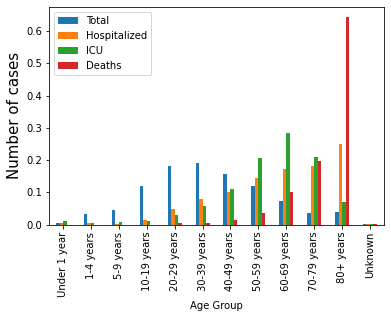

In [6]:
temp = data.div(data.sum(), axis=1)
temp.plot.bar()
plt.ylabel("Number of cases", fontsize=15)
temp

In [7]:
df_severe = temp

### Comorbidities 

In [8]:
data = pd.read_csv('../../data/AHS Public/covid19comorbidities1.csv')
data = data.set_index('Condition')
data

,Count,Percent
Condition,,
Hypertension,1678,86.0%
Cardio-Vascular Diseases,1037,53.1%
Dementia,1013,51.9%
Renal Diseases,895,45.9%
Diabetes,870,44.6%
Respiratory Diseases,797,40.8%
Cancer,446,22.8%
Stroke,413,21.2%
Liver Diseases,76,3.9%


We will assume those percentages are for hospitalized and death

,Count,Percent
Condition,,
Hypertension,0.231098,0.231183
Cardio-Vascular Diseases,0.142818,0.142742
Dementia,0.139512,0.139516
Renal Diseases,0.123261,0.123387
Diabetes,0.119818,0.119892
Respiratory Diseases,0.109764,0.109677
Cancer,0.061424,0.061290
Stroke,0.056879,0.056989
Liver Diseases,0.010467,0.010484


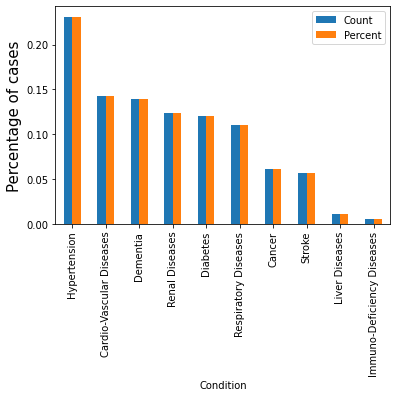

In [9]:
temp = pd.concat((data[['Count']], data['Percent'].str.rstrip('%').astype('float')/100), axis=1)
temp = temp.div(temp.sum(), axis=1)
temp.plot.bar()
plt.ylabel("Percentage of cases", fontsize=15)
temp

In [10]:
temp = pd.concat((data[['Count']], data['Percent'].str.rstrip('%').astype('float')/100), axis=1)
df_comorb1 = temp

Percent is the precentage of cases 

In [11]:
pd.read_csv('../../data/AHS Public/covid19comorbidities2.csv')

,Number of conditions,Non-Severe,Unnamed: 2,Non-ICU,Unnamed: 4,ICU,Unnamed: 6,Deaths,Unnamed: 8
0,NaN,Number,Percent,Number,Percent,Number,Percent,Number,Percent
1,No comorbidity,88819,67.2%,959,21.8%,141,19.4%,58,3.0%
2,With 1 condition,26634,20.2%,769,17.5%,152,20.9%,140,7.2%
3,With 2 conditions,9202,7.0%,796,18.1%,181,24.9%,257,13.2%
4,With 3 or more conditions,7420,5.6%,1866,42.5%,252,34.7%,1497,76.7%


,Non-Severe,Non-ICU,ICU
Number of conditions,,,
No comorbidity,88819,959,141
With 1 condition,26634,769,152
With 2 conditions,9202,796,181
With 3 or more conditions,7420,1866,252


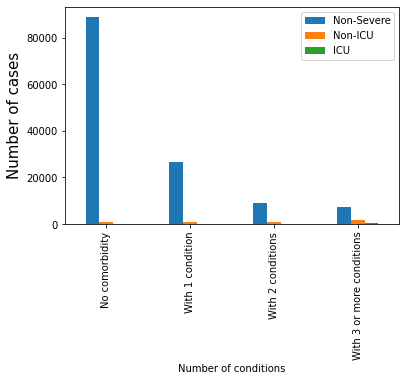

In [12]:
data = pd.read_csv('../../data/AHS Public/covid19comorbidities2.csv', skiprows=[1], usecols=[0, 1, 3, 5])
data = data.set_index('Number of conditions')
data.plot.bar()
plt.ylabel("Number of cases", fontsize=15)
data

In [13]:
data.sum()

Non-Severe    132075
Non-ICU         4390
ICU              726
dtype: int64

,Non-Severe,Non-ICU,ICU
Number of conditions,,,
No comorbidity,0.672489,0.218451,0.194215
With 1 condition,0.201658,0.175171,0.209366
With 2 conditions,0.069673,0.181321,0.249311
With 3 or more conditions,0.056180,0.425057,0.347107


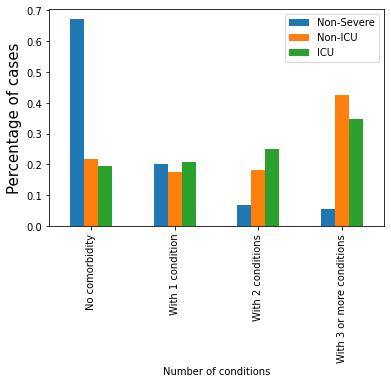

In [14]:
temp = data.div(data.sum(), axis=1)
temp.plot.bar()
plt.ylabel("Percentage of cases", fontsize=15)
temp

In [15]:
df_comorb2 = temp

## Synthetic data

In [16]:
data = pd.read_csv('../../data/AHS Public/covid19dataexport.csv')
data['Date reported'] = pd.to_datetime(data['Date reported'], format='%Y-%m-%d')

In [17]:
def oxygen_saturation(x):
    # percentage
    ages = ['Under 1 year', '1-4 years', '5-9 years', '10-19 years', '20-29 years',
       '30-39 years', '40-49 years', '50-59 years', '60-69 years',
       '70-79 years', '80+ years', 'Unknown']
    means = [90, 90, 90, 90, 90, 88, 89, 85, 80, 80, 80, 80]
    stds =  [1.5, 1.5, 1.5, 1.5, 1.5, 1.55, 1.26, 1.58, 1.10, 1.10, 1.10, 2.10]
    ix = ages.index(x['Age group'])
    return np.round(np.minimum(rd.gauss(mu=means[ix], sigma=stds[ix]**2), 99.9), 1)

def d_dimer(x):
    # ng/mL
    ages = ['Under 1 year', '1-4 years', '5-9 years', '10-19 years', '20-29 years',
       '30-39 years', '40-49 years', '50-59 years', '60-69 years',
       '70-79 years', '80+ years', 'Unknown']
    means = [294, 294, 294, 294, 294, 294, 387, 387, 854, 854, 1390, 400]
    stds =  [4, 4, 4, 4, 4, 4, 4.1, 4.1, 4.4, 4.4, 4.4, 10]
    ix = ages.index(x['Age group'])
    return np.round(rd.gauss(mu=means[ix], sigma=stds[ix]**2), 0)

def c_reactive(x):
    # mg/L
    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4863028/
    ages = ['Under 1 year', '1-4 years', '5-9 years', '10-19 years', '20-29 years',
       '30-39 years', '40-49 years', '50-59 years', '60-69 years',
       '70-79 years', '80+ years', 'Unknown']
    means = [0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 0.92, 1.04, 1.04, 1.04, np.nan]
    stds =  [0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.28, 0.28, 0.28, np.nan]
    ix = ages.index(x['Age group'])
    return np.round(rd.gauss(mu=means[ix], sigma=stds[ix]**2), 2)

In [18]:
def make_patient(x):
    value = []
    index = ['Hospitalized','ICU','Hypertension', 'Cardio-Vascular Diseases', 'Dementia',
             'Renal Diseases', 'Diabetes', 'Respiratory Diseases', 'Cancer',
             'Stroke', 'Liver Diseases', 'Immuno-Deficiency Diseases', 
             'Admission date', 'Oxygen saturation', 'D-Dimer', 'C reactive']
    # Hospitalized
    p = rd.random()/12
    value.append(df_severe['Hospitalized'][x['Age group']] > p)
    # ICU
    value.append(df_severe['ICU'][x['Age group']] > p)
    # Comorbodities
    for ix in index[2:12]:
        p = rd.random()
        if (value[0] | value[1] | (x['Case status']=='Died')):
            value.append(df_comorb1['Percent'][ix] > p)
        else:
            value.append(np.nan)  
    if (value[0] | value[1]):
        # Admission date
        value.append(x['Date reported']+pd.DateOffset(rd.randrange(7)))
        # Oxygen saturation
        value.append(oxygen_saturation(x))
        # D-dimer
        value.append(d_dimer(x))
        # Oxygen saturation
        value.append(oxygen_saturation(x))
        # Dat
    else:
        value.append(np.nan)
        value.append(np.nan)
        value.append(np.nan)
        value.append(np.nan)
    y = pd.Series(value, index=index)
    return x.append(y)

In [ ]:
synthetic = data.apply(make_patient, axis=1)

In [ ]:
synthetic.to_csv('covid19syntheticdata.csv')

In [27]:
df = pd.read_csv('covid19syntheticdata.csv')

In [28]:
df.head()

,Unnamed: 0,Date reported,Alberta Health Services Zone,Gender,Age group,Case status,Case type,Hospitalized,ICU,Hypertension,...,Diabetes,Respiratory Diseases,Cancer,Stroke,Liver Diseases,Immuno-Deficiency Diseases,Admission date,Oxygen saturation,D-Dimer,C reactive
0,0,2020-11-13,Calgary Zone,Female,1-4 years,Recovered,Confirmed,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2021-01-03,Calgary Zone,Female,5-9 years,Recovered,Confirmed,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2020-12-13,Edmonton Zone,Male,5-9 years,Recovered,Confirmed,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2021-01-05,Central Zone,Male,50-59 years,Recovered,Confirmed,True,True,False,...,False,True,True,True,False,False,2021-01-05,85.1,383.0,84.0
4,4,2021-01-30,Calgary Zone,Female,1-4 years,Recovered,Confirmed,False,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
df.shape

(139143, 23)

In [32]:
df = df[df['Case status'] != 'Active']
df = df[df['Case type']=='Confirmed']
df = df[df['ICU']]
df = df[df['Hospitalized']]

In [33]:
df.shape

(83956, 23)

In [35]:
df.head()

,Unnamed: 0,Date reported,Alberta Health Services Zone,Gender,Age group,Case status,Case type,Hospitalized,ICU,Hypertension,...,Diabetes,Respiratory Diseases,Cancer,Stroke,Liver Diseases,Immuno-Deficiency Diseases,Admission date,Oxygen saturation,D-Dimer,C reactive
3,3,2021-01-05,Central Zone,Male,50-59 years,Recovered,Confirmed,True,True,False,...,False,True,True,True,False,False,2021-01-05,85.1,383.0,84.0
7,7,2021-01-14,Calgary Zone,Female,40-49 years,Recovered,Confirmed,True,True,False,...,False,True,False,False,False,False,2021-01-17,89.1,377.0,88.4
11,11,2020-12-16,Calgary Zone,Male,10-19 years,Recovered,Confirmed,True,True,True,...,True,True,False,True,False,False,2020-12-19,91.3,299.0,90.1
12,12,2020-12-04,Edmonton Zone,Female,20-29 years,Recovered,Confirmed,True,True,False,...,True,True,True,True,False,False,2020-12-06,90.9,305.0,88.9
14,14,2020-11-26,Edmonton Zone,Female,40-49 years,Recovered,Confirmed,True,True,True,...,False,False,True,False,False,False,2020-11-26,86.9,397.0,89.7


In [60]:
temp = df[['Hypertension', 'Cardio-Vascular Diseases', 'Dementia',
       'Renal Diseases', 'Diabetes', 'Respiratory Diseases', 'Cancer',
       'Stroke', 'Liver Diseases', 'Immuno-Deficiency Diseases']]
temp

,Hypertension,Cardio-Vascular Diseases,Dementia,Renal Diseases,Diabetes,Respiratory Diseases,Cancer,Stroke,Liver Diseases,Immuno-Deficiency Diseases
3,False,True,True,False,False,True,True,True,False,False
7,False,False,True,True,False,True,False,False,False,False
11,True,True,False,False,True,True,False,True,False,False
12,False,True,False,True,True,True,True,True,False,False
14,True,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...
139135,True,True,False,True,False,False,False,False,False,False
139137,True,False,False,False,True,True,False,False,False,False
139139,True,True,True,False,True,False,False,True,False,False
139141,True,False,False,False,True,False,False,False,False,False


In [61]:
temp = df[['Hypertension', 'Cardio-Vascular Diseases', 'Dementia',
       'Renal Diseases', 'Diabetes', 'Respiratory Diseases', 'Cancer',
       'Stroke', 'Liver Diseases', 'Immuno-Deficiency Diseases']]
temp
newcol = pd.DataFrame(temp.sum(axis=1), columns=["Number of comorbidities"])
newcol

,Number of comorbidities
3,5.0
7,3.0
11,5.0
12,6.0
14,2.0
...,...
139135,3.0
139137,3.0
139139,5.0
139141,2.0


In [62]:
temp = df[['Hypertension', 'Cardio-Vascular Diseases', 'Dementia',
       'Renal Diseases', 'Diabetes', 'Respiratory Diseases', 'Cancer',
       'Stroke', 'Liver Diseases', 'Immuno-Deficiency Diseases']]
newcol = pd.DataFrame(temp.sum(axis=1), columns=["Number of comorbidities"])
pd.concat([temp,newcol],axis=1)

,Hypertension,Cardio-Vascular Diseases,Dementia,Renal Diseases,Diabetes,Respiratory Diseases,Cancer,Stroke,Liver Diseases,Immuno-Deficiency Diseases,Number of comorbidities
3,False,True,True,False,False,True,True,True,False,False,5.0
7,False,False,True,True,False,True,False,False,False,False,3.0
11,True,True,False,False,True,True,False,True,False,False,5.0
12,False,True,False,True,True,True,True,True,False,False,6.0
14,True,False,False,False,False,False,True,False,False,False,2.0
...,...,...,...,...,...,...,...,...,...,...,...
139135,True,True,False,True,False,False,False,False,False,False,3.0
139137,True,False,False,False,True,True,False,False,False,False,3.0
139139,True,True,True,False,True,False,False,True,False,False,5.0
139141,True,False,False,False,True,False,False,False,False,False,2.0


In [50]:
?pd.DataFrame.append